In [1]:
import numpy as np
import pandas as pd
import time
import h5pyd
import geopandas as gpd
from dw_tap.data_fetching import getData
from dw_tap.power_output import estimate_power_output
from dw_tap.lom import run_lom

z_turbine = 40 # turbine height in [m]
#lat, lon = 39.32856, -89.40238
lat, lon = 39.32374225, -89.40056775

# The buildings are the same as in the previous tests
obstacle_file = "../sites/180-5BuildingsManual.geojson"
#obstacle_file = "../sites/180-Manual1.geojson"

t_start = time.time()

#Read in data from CSV file instead of hsds + getData
#atmospheric_df = pd.read_csv("../data/180_1year_12hourgranularity.csv")

# There seems to be a problem with the input from this file
atmospheric_df = pd.read_csv("../data/180_2000rows_under_review.csv")

# Temporary (later need to resave csv without index column) 
if "Unnamed: 0" in atmospheric_df.columns:
    atmospheric_df.drop(columns=["Unnamed: 0"], inplace=True)

obstacles_df = gpd.read_file(obstacle_file)
# Leave in only relevant columns
obstacles_df = obstacles_df[["height", "geometry"]]

xy_turbine = [np.array([lon, lat])]

t_lom_start = time.time()
predictions_df = \
    run_lom(atmospheric_df, obstacles_df, xy_turbine, z_turbine,
            check_distance=True)
t_lom = time.time() - t_lom_start
print('Running LOM: %.2f (s)' % t_lom)

t_power_start = time.time()
kw, above_curve, below_curve, above_curve_list, below_curve_list = \
    estimate_power_output(predictions_df, atmospheric_df["temp"], atmospheric_df["pres"])  
t_power = time.time() - t_power_start
print('Power estimation: %.2f (s)' % t_power)

t_total = time.time()-t_start
print('Total time: %.2f (s)' % t_total)

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-01-19 11:53:22.536914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done with loading ML model.
LOM computation time : 0.29033899307250977  sec
Running LOM: 1.77 (s)
Power estimation: 0.04 (s)
Total time: 1.85 (s)


In [2]:
atmospheric_df

,datetime,ws,wd,temp,pres
0,2007-01-01 00:00:00,7.787228,233.140734,282.541870,98487.245180
1,2007-01-01 01:00:00,8.213125,238.568689,281.693481,98488.453970
2,2007-01-01 02:00:00,7.102716,231.218874,280.445251,98531.895849
3,2007-01-01 03:00:00,8.614593,237.906204,279.526672,98545.118190
4,2007-01-01 04:00:00,8.448002,237.531201,278.693512,98548.458955
...,...,...,...,...,...
1996,2007-03-25 04:00:00,7.438345,188.216391,293.052460,99921.691173
1997,2007-03-25 05:00:00,7.546097,196.957800,292.841888,99925.496337
1998,2007-03-25 06:00:00,6.790068,192.169340,292.085022,99939.793161
1999,2007-03-25 07:00:00,6.690274,194.352947,291.499084,99944.097908


In [3]:
xy_turbine

[array([-89.40056775,  39.32374225])]

In [4]:
obstacles_df

,height,geometry
0,10,"POLYGON ((-89.40211 39.32865, -89.40212 39.328..."
1,10,"POLYGON ((-89.40247 39.32839, -89.40248 39.328..."
2,10,"POLYGON ((-89.40248 39.32817, -89.40248 39.327..."
3,10,"POLYGON ((-89.40224 39.32814, -89.40225 39.327..."
4,10,"POLYGON ((-89.40175 39.32828, -89.40176 39.328..."


In [5]:
predictions_df

,timestamp,ws,ws-adjusted
0,2007-01-01 00:00:00,7.787228,7.771351
1,2007-01-01 01:00:00,8.213125,8.204848
2,2007-01-01 02:00:00,7.102716,7.086055
3,2007-01-01 03:00:00,8.614593,8.604501
4,2007-01-01 04:00:00,8.448002,8.437731
...,...,...,...
1996,2007-03-25 04:00:00,7.438345,4.948853
1997,2007-03-25 05:00:00,7.546097,6.748090
1998,2007-03-25 06:00:00,6.790068,5.588149
1999,2007-03-25 07:00:00,6.690274,5.815836


In [6]:
predictions_df["ws-adjusted"].isna().value_counts()

False    2001
Name: ws-adjusted, dtype: int64

<AxesSubplot:>

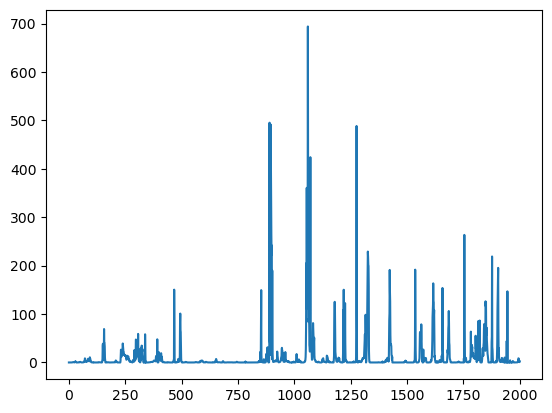

In [7]:
(predictions_df["ws"] - predictions_df["ws-adjusted"]).plot()

<AxesSubplot:xlabel='wd', ylabel='Count'>

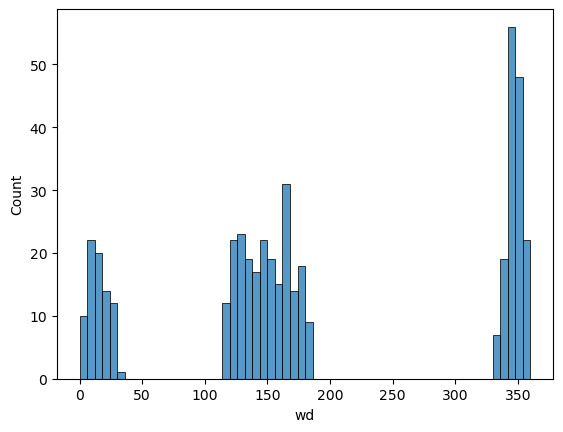

In [23]:
import seaborn as sns
negative_ws_adjusted = predictions_df["ws-adjusted"][predictions_df["ws-adjusted"] < 0]

# Use the index of negative_ws_adjusted to select rows from atmospheric_df to find the corresponding wind direction values;
# show distribution of wind direction values 
sns.histplot(atmospheric_df.loc[negative_ws_adjusted.index].wd, bins=60)

<AxesSubplot:xlabel='ws', ylabel='Count'>

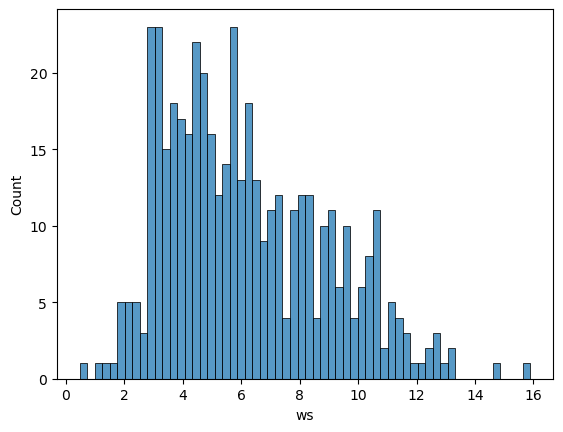

In [25]:
# Show wind speeds that correspond to the wind directions selected above 
sns.histplot(atmospheric_df.loc[negative_ws_adjusted.index].ws, bins=60)

<AxesSubplot:>

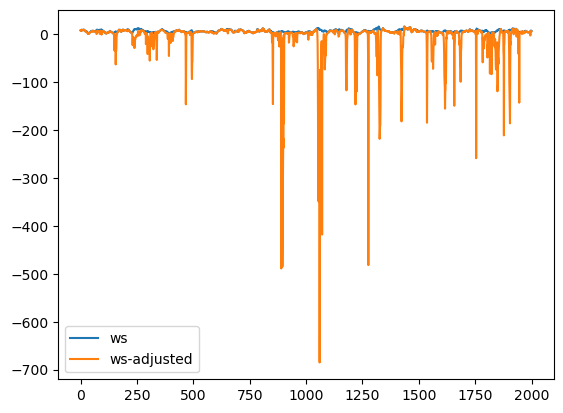

In [11]:
predictions_df[["ws", "ws-adjusted"]][:2000].plot()

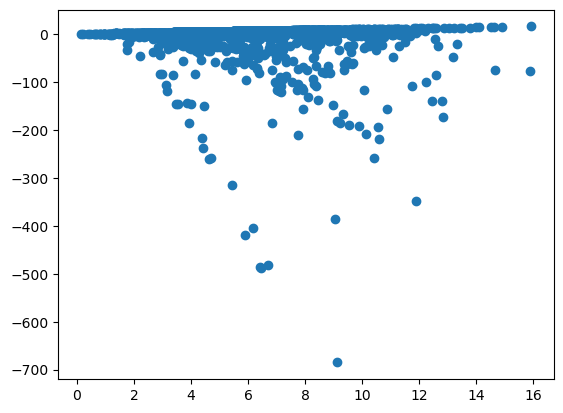

In [10]:
tmp = predictions_df # [predictions_df["nonlinear"] > 0]

import matplotlib.pyplot as plt
plt.scatter(tmp["ws"], tmp["ws-adjusted"])

In [8]:
tmp["ws"].max()

13.72442114431899

In [9]:
predictions_df["ws-adjusted"].max()

13.22385572959052

In [15]:
##### Cells below can be used for demonstration purposes

In [9]:
# atmospheric_df

In [10]:
# obstacles_df #height is in meters; geometry has polygons in (lat,lon) pairs

In [11]:
# xy_turbine # location of turbine in lat,lon

In [12]:
# z_turbine # hub height in meters 

In [14]:
# predictions_df = \
#     run_lom(atmospheric_df, obstacles_df, xy_turbine, z_turbine)

In [13]:
# predictions_df